In [1]:
# =======================
# Load the MNIST handwritten digit dataset and return DataLoaders for training and testing.
# Each image is converted to a PyTorch tensor and normalized to the [0, 1] range.
# DataLoaders enable efficient batching, shuffling, and iteration during training.
# =======================
from torchvision import datasets, transforms # Import MNIST dataset and image transforms
from torch.utils.data import DataLoader # For batching and loading the dataset

def get_mnist_loaders(batch_size=128):

  # Convert images to PyTorch tensors with values scaled to [0, 1]
  transform = transforms.ToTensor()

  # Download and load the training dataset
  train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

  # Download and load the test dataset
  test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

  # Wrap datasets in DataLoaders to enable batching and shuffling
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

  return train_loader, test_loader


In [3]:
# =======================
# Visualize a batch of MNIST digit images from the training dataset.
# This function loads a mini-batch using get_mnist_loaders() and displays the digits with their labels.
# Useful for quickly inspecting the raw input data before training.
# =======================
import matplotlib.pyplot as plt # For plotting and displaying images
def visualize_batch(batch_size=16):
  # Load a mini-batch of training data
  train_loader, _ = get_mnist_loaders(batch_size)
  images, labels = next(iter(train_loader)) # Get the first batch

  # Create a horizontal grid of images
  plt.figure(figsize=(10, 4))
  for i in range(batch_size):
    plt.subplot(2, batch_size // 2, i + 1) # 2 rows, batch_size/2 columns
    plt.imshow(images[i][0], cmap='gray') # Show the image (channel 0 since MNIST is grayscale)
    plt.title(f"Label: {labels[i].item()}")
    plt.axis('off')
  plt.tight_layout()
  plt.show()

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 478kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.44MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 3.25MB/s]


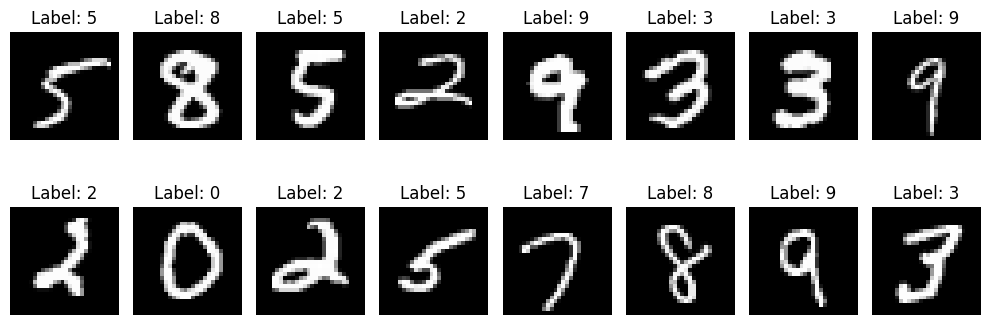

In [4]:
visualize_batch()

In [5]:
# =======================
# Define a fully-connected Autoencoder for compressing and reconstructing MNIST digit images.
# Architecture:
#   Encoder: 784 → 128 → 32
#   Decoder: 32 → 128 → 784
# The model learns to compress 28x28 images into a 32-dimensional latent space and reconstruct them.
# =======================
import torch
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=128, latent_dim=32):
      super().__init__()

      # Encoder: compress input image to a 32-dimensional latent vector
      self.encoder = nn.Sequential(
          nn.Linear(input_dim, hidden_dim), # Flattened image → hidden layer
          nn.ReLU(),
          nn.Linear(hidden_dim, latent_dim), # Hidden → latent representation
      )

      # Decoder: reconstruct image from the latent vector
      self.decoder = nn.Sequential(
          nn.Linear(latent_dim, hidden_dim), # Latent → hidden layer
          nn.ReLU(),
          nn.Linear(hidden_dim, input_dim), # Hidden → reconstructed image
          nn.Sigmoid(),  # Match MNIST pixel range [0, 1]
      )

    def forward(self, x):
      x = x.view(x.size(0), -1) # Flatten image: [batch, 1, 28, 28] → [batch, 784]
      z = self.encoder(x) # Encode to latent vector
      out = self.decoder(z) # Decode back to reconstructed image
      return out

In [9]:
# Load data
train_loader, test_loader = get_mnist_loaders()

In [13]:
# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Autoencoder()
model.to(device)

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=784, bias=True)
    (3): Sigmoid()
  )
)

In [14]:
# =======================
# Set up the loss function and optimizer for training the autoencoder.
# We use Binary Cross Entropy (BCE) since the pixel values are in the [0, 1] range,
# and Adam optimizer for efficient gradient updates.
# =======================
criterion = nn.BCELoss() # Measures reconstruction loss between predicted and actual pixel values
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [15]:
# =======================
# Train the autoencoder for a number of epochs using the training dataset.
# For each batch:
#   - Forward pass: input → encoded → decoded
#   - Compute reconstruction loss (BCE)
#   - Backpropagate and update model weights
# The average loss for each epoch is printed to monitor training progress.
# =======================
epochs = 10
for epoch in range(epochs):
  running_loss = 0.0
  for batch in train_loader:
    inputs, _ = batch # We ignore the labels; autoencoders are unsupervised
    inputs = inputs.to(device)
    optimizer.zero_grad()
    outputs = model(inputs)
    # Compute loss between reconstruction and original (flattened) input
    loss = criterion(outputs, inputs.view(inputs.size(0), -1))
    loss.backward()
    optimizer.step() # Update weights using gradients
    running_loss += loss.item()
  avg_loss = running_loss / len(train_loader)
  print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

Epoch 1/10, Loss: 0.2028
Epoch 2/10, Loss: 0.1228
Epoch 3/10, Loss: 0.1065
Epoch 4/10, Loss: 0.1000
Epoch 5/10, Loss: 0.0961
Epoch 6/10, Loss: 0.0932
Epoch 7/10, Loss: 0.0910
Epoch 8/10, Loss: 0.0893
Epoch 9/10, Loss: 0.0879
Epoch 10/10, Loss: 0.0868


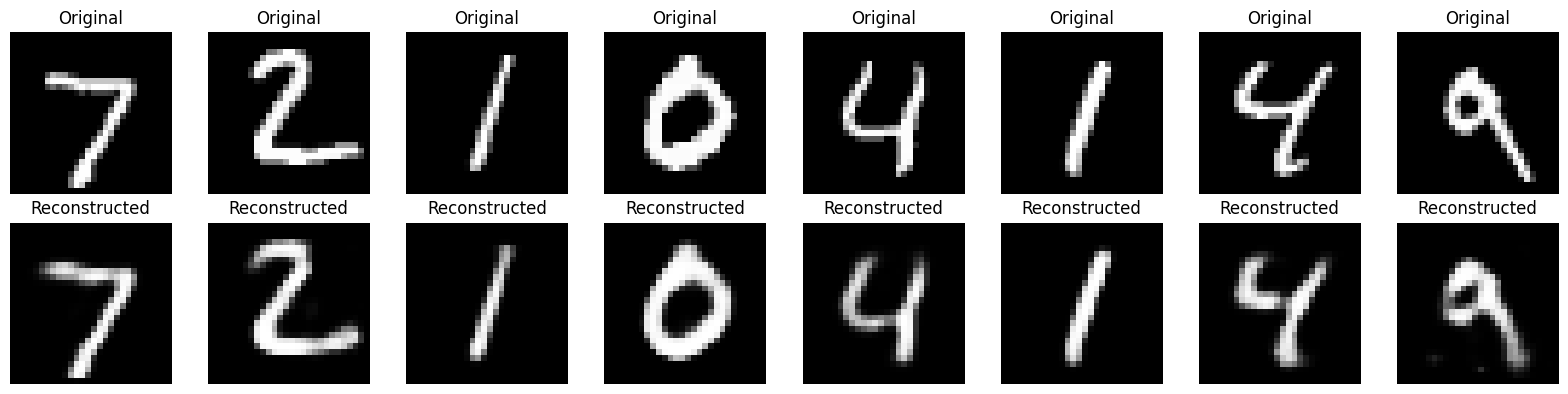

In [16]:
# Get a small batch
model.eval()
with torch.no_grad():
    sample_imgs, _ = next(iter(test_loader))
    sample_imgs = sample_imgs.to(device)
    reconstructed = model(sample_imgs)

# Plot original vs reconstructed
n = 8
plt.figure(figsize=(16, 4))
for i in range(n):
    # Original
    plt.subplot(2, n, i + 1)
    plt.imshow(sample_imgs[i][0].cpu(), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    # Reconstructed
    plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed[i].view(28, 28).cpu(), cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')

plt.tight_layout()
plt.show()


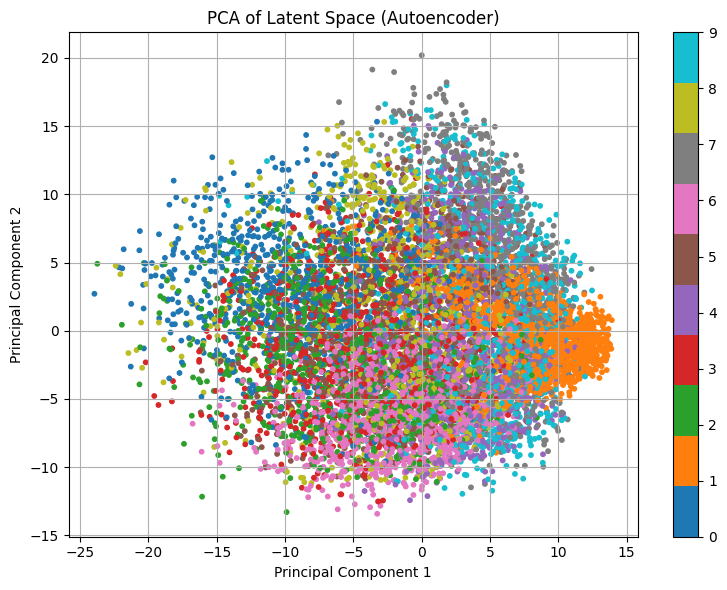

In [17]:
from sklearn.decomposition import PCA
# Collect latent vectors and labels
latents = []
labels = []

model.eval()
with torch.no_grad():
    for images, lbls in test_loader:
        images = images.to(device)
        z = model.encoder(images.view(images.size(0), -1))
        latents.append(z.cpu())
        labels.append(lbls)

latents = torch.cat(latents).numpy()   # e.g shape: [10000, 32]
labels = torch.cat(labels).numpy()     # e.g shape: [10000]

# Apply PCA
pca = PCA(n_components=2)
reduced = pca.fit_transform(latents)   # e.g shape: [10000, 2]

# Plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=labels, cmap='tab10', s=10)
plt.colorbar(scatter, ticks=range(10))
plt.title("PCA of Latent Space (Autoencoder)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()